# AUTHOR : Slav Yolov
# Faculty number : 5EB3100235

##  credit card approval predictor

Use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository.

In [ ]:
!pip install pandas-profiling==3.6.2

In [ ]:
!pip install shap

# dataset description :

http://archive.ics.uci.edu/ml/datasets/credit+approval

```
6.  Number of Attributes: 15 + class attribute

7.  Attribute Information:

    A1:	b, a.
    A2:	continuous.
    A3:	continuous.
    A4:	u, y, l, t.
    A5:	g, p, gg.
    A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7:	v, h, bb, j, n, z, dd, ff, o.
    A8:	continuous.
    A9:	t, f.
    A10:	t, f.
    A11:	continuous.
    A12:	t, f.
    A13:	g, p, s.
    A14:	continuous.
    A15:	continuous.
    A16: +,-         (class attribute)

8.  Missing Attribute Values:
    37 cases (5%) have one or more missing values.  The missing
    values from particular attributes are:

    A1:  12
    A2:  12
    A4:   6
    A5:   6
    A6:   9
    A7:   9
    A14: 13

9.  Class Distribution
  
    +: 307 (44.5%)
    -: 383 (55.5%)
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats as st
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score


from pandas_profiling import ProfileReport

In [2]:
# Load dataset
credit_df = pd.read_csv("cc_approvals.csv", header=None)
credit_df.columns = credit_df.columns.astype(str)

print(credit_df.head())
print(credit_df.info())

# 1,2,7,11,13,14

   0      1      2  3  4  5  6     7  8  9  10 11 12   13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g   43  560  +
2  a   24.5  0.500  u  g  q  h  1.50  t  f   0  f  g  280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  120    0  +
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 n

In [3]:
# Data profiling :

profile = ProfileReport(df=credit_df, title="Pandas Profiling Report")
profile.to_widgets()
# profile.to_notebook_iframe()
# profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Findings :

### EDA
- feature 3 and 4 are exactly correlated. This means that we have no gain using both. One of them can be removed from the model training
- ??? column 13 is coded as categorical but looks continuous thus data type changed (why these columns 10 and 13 were dropped)
- Target is fairly balanced (55% class 0 and 45% class 1) therefore HoldoutCV should be ok as a start
- After countplot - some fields look numeric. This will be handled in the dataprep function

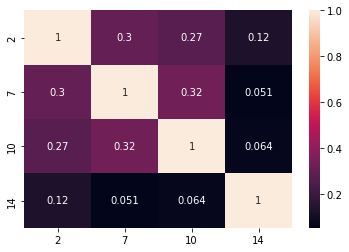

In [4]:
#plotting the heatmap for correlation - Numerical
ax = sns.heatmap(credit_df.corr(), annot=True)

In [5]:
categorical_columns = list(credit_df.select_dtypes(['object']).columns)
categorical_columns_wo_target = categorical_columns.copy()
categorical_columns_wo_target.remove('15')

def run_countplot(data: pd.DataFrame, cols_subs, target_col):
    f, axs = plt.subplots(1, len(cols_subs), figsize=(10, 4))
    for ax, col in zip(axs, cols_subs):
        sns.countplot(data=data, x=col, hue=target_col, ax=ax)


    f.tight_layout()

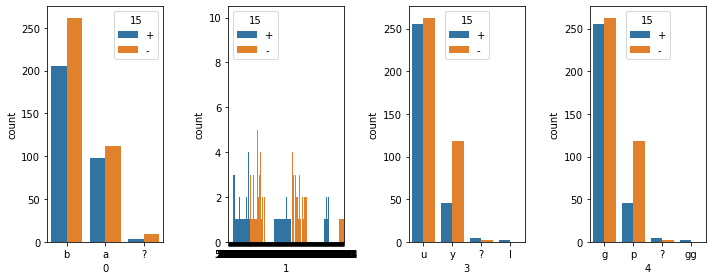

In [6]:
cols_subs = categorical_columns_wo_target[:4]
run_countplot(data=credit_df, cols_subs=cols_subs, target_col='15')

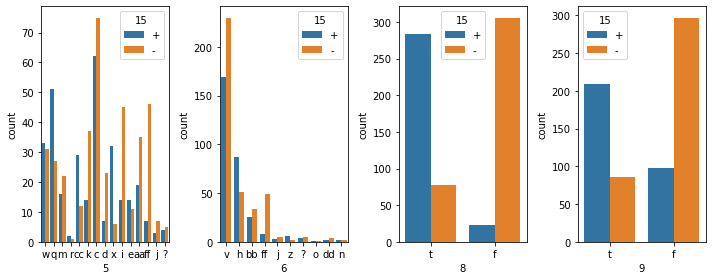

In [7]:
cols_subs = categorical_columns_wo_target[4:8]
run_countplot(data=credit_df, cols_subs=cols_subs, target_col='15')

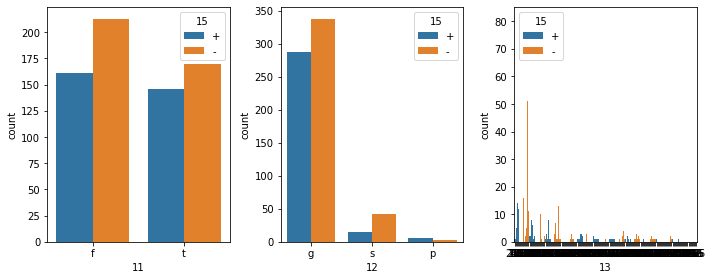

In [8]:
cols_subs = categorical_columns_wo_target[8:]
run_countplot(data=credit_df, cols_subs=cols_subs, target_col='15')

## Data processing

In [26]:
def data_processing(input_df: pd.DataFrame, normalize=True):
    df = input_df.copy(deep=True)
    # STEP 1 : basic data prepartion (missing values, recode the target variable)
    
    # Replace the '?'s with NaN
    df = df.replace("?",np.NaN)
    
    #Drop informative columns
    df = df.drop([df.columns[10],df.columns[13]], axis=1)
    
    # Replace the '?'s with NaN
    df = df.replace(" ","")
    df = df.replace("?",np.NaN)
    df['15'] = df['15'].replace("+",1)
    df['15'] = df['15'].replace("-",0)
    df.dropna(how='any', inplace=True)
    
    # Cast numeric columns to the right type
    df['1'] = df['1'].astype(float)
    df['2'] = df['2'].astype(float)
    df['7'] = df['7'].astype(float)
#     df[10] = df[10].astype(float) # columns is dropped
#     df[13] = df[13].astype(int) # columns is dropped
    df['14'] = df['14'].astype(int)
    
    if normalize:
        # STEP 2 : LabelEncoder
        le = LabelEncoder()

        for col in df.columns:
            # Compare if the dtype is object
            if df[col].dtype=='object':
            # Use LabelEncoder to do the numeric transformation
                df[col]=le.fit_transform(df[col])

        # STEP 3 : Normalization
        data_array = df.values # convert to np.array
        
        # Segregate features and labels into separate feature and target arrays
        X,y = data_array[:,0:13], data_array[:,13]


        # Instantiate MinMaxScaler and use it to rescale the features (in practive effect only on the categorical ones)
        scaler = MinMaxScaler(feature_range=(0,1))
        X = scaler.fit_transform(X) 

    else:
        # get dummies
        orig_col_names_categorical = []
        for col in df.columns:
            # Compare if the dtype is object
            if df[col].dtype=='object':
                orig_col_names_categorical.append(col)
                df = pd.concat([df, pd.get_dummies(df[col], drop_first=True)], axis=1)
                
        # drop original features
        df = df.drop(orig_col_names_categorical,axis=1)
        
        X = df.loc[:, df.columns != '15'].values
        y = df['15'].values
        
    return df, X, y

## Modeling

### Baseline

In [41]:
### baseline algorithm
# We will use the mode of the target variable to create a baseline

credit_updated_df, X, y = data_processing(input_df=credit_df, normalize=False)

print(X.shape, y.shape)

# Split into train and test sets
# N0tes : Target is fairly balanced (55% class 0 and 45% class 1) therefore HoldoutCV should be ok as a start
# print(credit_updated_df[15].value_counts())
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

print("MODE", st.mode(y))
y_pred = np.array([0] * len(y_test))

# Increment to the evaluation table
# Because we have only 1 class f1_score, precision, and recall cannot be calculated thus we get a warning
# https://stackoverflow.com/a/47285662
model_name = "baseline"
evaluation_df = pd.DataFrame({'model_name': model_name,
                              'accuracy': accuracy_score(y_pred=y_pred, y_true=y_test), 
                              'recall': recall_score(y_pred=y_pred, y_true=y_test),
                              'precision' : precision_score(y_pred=y_pred, y_true=y_test),
                              'f1_score': f1_score(y_pred=y_pred, y_true=y_test)
                             }, 
                             index=[0])
evaluation_df

(659, 35) (659,)
MODE ModeResult(mode=array([0], dtype=int64), count=array([361]))


C:\Users\natal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy,recall,precision,f1_score
0,baseline,0.565657,0.0,0.0,0.0


### Logistic Regression

In [42]:
# Working data Logistic Regression
credit_updated_df, X, y = data_processing(input_df=credit_df, normalize=True)

print(X.shape, y.shape)

# Split into train and test sets
# N0tes : Target is fairly balanced (55% class 0 and 45% class 1) therefore HoldoutCV should be ok as a start
# print(credit_updated_df[15].value_counts())
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

# Instantiate a LogisticRegression classifier with default parameter values
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

# Evaluate the performance
y_pred = log_reg.predict(X_test)
prediction_df = pd.DataFrame({'y_true':y_test, 
                              'prediction':y_pred})


(659, 13) (659,)


In [43]:
print("Confusion matrix : \n\n", confusion_matrix(y_pred=y_pred, y_true=y_test))
confusion_matrix(y_pred=y_pred, y_true=y_test)

print('accuracy_score: %.3f' % accuracy_score(y_pred=y_pred, y_true=y_test))
print('Recall: %.3f' % recall_score(y_pred=y_pred, y_true=y_test))
print('Precision: %.3f' % precision_score(y_pred=y_pred, y_true=y_test))
print('f1_score: %.3f' % f1_score(y_pred=y_pred, y_true=y_test))

Confusion matrix : 

 [[88 24]
 [ 6 80]]
accuracy_score: 0.848
Recall: 0.930
Precision: 0.769
f1_score: 0.842


In [44]:
# Increment to the evaluation table
model_name = "logistic_regression"
evaluation_log_reg_df = pd.DataFrame({'model_name': model_name,
                              'accuracy': accuracy_score(y_pred=y_pred, y_true=y_test), 
                              'recall': recall_score(y_pred=y_pred, y_true=y_test),
                              'precision' : precision_score(y_pred=y_pred, y_true=y_test),
                              'f1_score': f1_score(y_pred=y_pred, y_true=y_test)
                             }, 
                             index=[0])

evaluation_df = evaluation_df.append(evaluation_log_reg_df)

C:\Users\natal\AppData\Local\Temp\ipykernel_2228\110203668.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(evaluation_log_reg_df)


### Random Forest

In [45]:
credit_updated_df, X, y = data_processing(input_df=credit_df, normalize=False)

print(X.shape, y.shape)

# Split into train and test sets
# N0tes : Target is fairly balanced (55% class 0 and 45% class 1) therefore HoldoutCV should be ok as a start
# print(credit_updated_df[15].value_counts())
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

# Grid Search to find the optimal parameters among the search set
rfc = RandomForestClassifier()

'''
n_estimators - The number of trees in the forest.
min_samples_split - The minimum number of samples required to split an internal node:
max_depth - The maximum depth of the tree]
'''


param_grid = dict(n_estimators=[1,100,500],
                  min_samples_split=[3,5,10],
                  max_depth=[3,5,10])

grid = GridSearchCV(rfc,param_grid,scoring='accuracy',cv=5)
grid.fit(X,y)

(659, 35) (659,)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [1, 100, 500]},
             scoring='accuracy')

In [47]:
print('Best Hyperparameters:',grid.best_params_)
print('Best Score:',grid.best_score_)

Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.8650358547305113


In [48]:
grid_cols_subset = ['param_n_estimators','param_max_depth','param_min_samples_split','mean_test_score','rank_test_score']
scores_df = pd.DataFrame(grid.cv_results_)[grid_cols_subset].sort_values(by='mean_test_score', ascending=False)
scores_df

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
4,100,3,5,0.865036,1
2,500,3,3,0.858964,2
14,500,5,5,0.857460,3
13,100,5,5,0.855945,4
17,500,5,10,0.854441,5
10,100,5,3,0.854418,6
16,100,5,10,0.854418,6
8,500,3,10,0.852915,8
25,100,10,10,0.852903,9
20,500,10,3,0.852892,10


In [49]:
params_best = {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 500}

rfc_best = RandomForestClassifier(**params_best)
rfc_best.fit(X, y)

# Evaluate the performance
y_pred_rf = rfc_best.predict(X_test)
prediction_rf_df = pd.DataFrame({'y_true':y_test, 
                                 'prediction':y_pred_rf})\

print("Confusion matrix : \n\n", confusion_matrix(y_pred=y_pred_rf, y_true=y_test))
confusion_matrix(y_pred=y_pred, y_true=y_test)

print('accuracy_score: %.3f' % accuracy_score(y_pred=y_pred_rf, y_true=y_test))
print('Recall: %.3f' % recall_score(y_pred=y_pred_rf, y_true=y_test))
print('Precision: %.3f' % precision_score(y_pred=y_pred_rf, y_true=y_test))
print('f1_score: %.3f' % f1_score(y_pred=y_pred_rf, y_true=y_test))

Confusion matrix : 

 [[101  11]
 [ 14  72]]
accuracy_score: 0.874
Recall: 0.837
Precision: 0.867
f1_score: 0.852


In [50]:
# Increment to the evaluation table
model_name = "random_forest"
evaluation_rf_df = pd.DataFrame({'model_name': model_name,
                              'accuracy': accuracy_score(y_pred=y_pred_rf, y_true=y_test), 
                              'recall': recall_score(y_pred=y_pred_rf, y_true=y_test),
                              'precision' : precision_score(y_pred=y_pred_rf, y_true=y_test),
                              'f1_score': f1_score(y_pred=y_pred_rf, y_true=y_test)
                             }, 
                             index=[0])

evaluation_df = evaluation_df.append(evaluation_rf_df)

C:\Users\natal\AppData\Local\Temp\ipykernel_2228\439986763.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(evaluation_rf_df)


In [51]:
# Conclusion :

evaluation_df

# The best model among the tested is the RandomForest Classifier. 
# It has the best performance in all metrics observed.
# It significantly beats the baseline (mode) in terms of accuracy

,model_name,accuracy,recall,precision,f1_score
0,baseline,0.565657,0.000000,0.000000,0.000000
0,logistic_regression,0.848485,0.930233,0.769231,0.842105
0,random_forest,0.873737,0.837209,0.867470,0.852071


In [331]:
!pip install shap

In [334]:
import shap

# Fits the explainer
explainer = shap.Explainer(rfc_best.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 199it [03:10,  1.01it/s]                                                                        


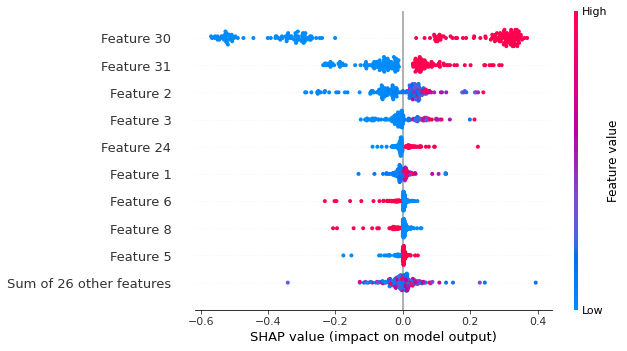

In [335]:
shap.plots.beeswarm(shap_values)

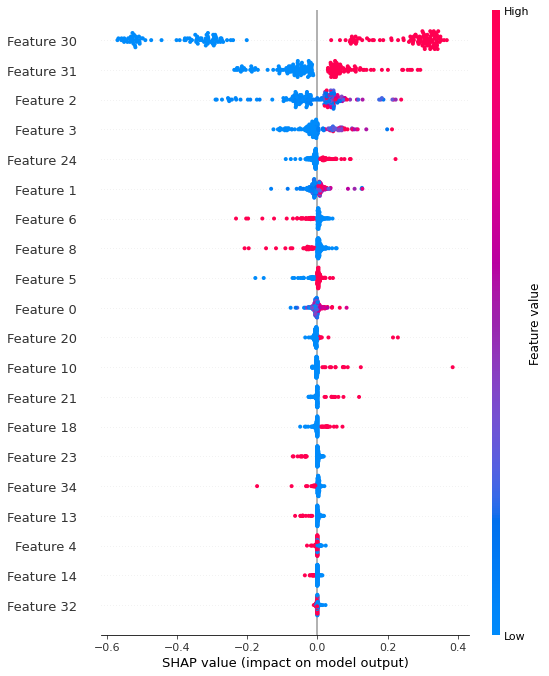

In [337]:
shap.summary_plot(shap_values)